In [1]:
import requests
import pandas as pd
from flatten_json import flatten
from utils.io import dict_to_yaml
from utils.io import yaml_to_dict
import numpy as np
from typing import List, Tuple, Dict, Union
from itertools import compress
import pandas as pd
import re
import datetime as dt
from cleanco import basename
from json import dumps
import matplotlib.pyplot as plt
import seaborn as sns

# from projects.lobbying.postproc import terms_present
import matplotlib.colors as mc

id = "lgulden"
apikey = "4d1a4bc3be920e859b3862a25d3725d741028d42"
data_gov_api_key = "n4TEYUedn3STcnsxQi7JllzXZgfB6Dqg5pV2068E"
%load_ext jupyter_black

In [2]:
def terms_present(phrase, term_list, find_any=True):
    """utility function to see if terms in terms_list are present in a given phrase
    Args:
        phrase: phrase to be searched
        term_list: list of strings to be searched for within phrase
        find_any: boolean -- true if function should return true if any of the terms are in the phrase;
            false if the function should only return true if all terms are present
    Returns:
        int: 1 if one or more of the terms are present in phrase, 0 otherwise
    """
    if not isinstance(phrase, str):
        raise TypeError("phrase must be a string")
    if not isinstance(term_list, list):
        raise TypeError(
            "term_list must be a list of strings (even if it is a list of length 1)"
        )
    if phrase is None:
        return 0
    n_present = 0

    for term in term_list:
        if isinstance(term, list):
            if terms_present(phrase, term, find_any=False):
                if find_any:
                    return 1
                n_present += 1
        elif term.lower() in phrase.lower():
            if find_any:
                return 1
            n_present += 1
    if n_present == len(term_list):
        return 1
    return 0

In [ ]:
config = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/config_ccs_lda.yml"
)
term_list_dict = yaml_to_dict(config["search_term_list_path"])
law_list_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/ccs_laws.yml"
)

In [ ]:
authenticated_session = api_authenticate(
    config["authentication_endpoint"],
    config["lda_username"],
    config["lda_apikey"],
)
result = authenticated_session.get(
    config["filings_endpoint"],
    params={"filing_specific_lobbying_issues": f"{search_string}"},
)

In [6]:
def get_list_govt_entities(entity_endpoint: str, session: object):
    """Queries constants endpoint to get a standardized list of government entities"""
    govt_entities = session.get(entity_endpoint, timeout=60)
    entity_df = pd.DataFrame(govt_entities.json())
    entities = sorted([x.lower() for x in list(entity_df["name"])])
    return entities


def api_authenticate(
    authentication_endpoint,
    username,
    apikey,
    username_key="username",
    password_key="password",
):
    """logs in to the api using provided authentication endpoint and credentials"""
    authenticated_session = requests.Session()

    authenticated_session.post(
        authentication_endpoint,
        json={
            username_key: username,
            password_key: apikey,
        },
        timeout=60,
    )

    return authenticated_session


def substitute(
    x: str,
    use_basename: bool = False,
    re_types: str = r"[^\w\s]",
    replace_str: str = "",
):
    """wrapper function for regular expression substitute funciton, linked with basename lib"""
    # use basename for company names
    if not isinstance(x, str):
        x = ""
    if use_basename:
        return basename(re.sub(re_types, replace_str, x))
    # don't use basename for general strings
    return re.sub(re_types, replace_str, x).rstrip().lstrip()


def parse_client_names(
    input_df, config, client_rename_col="client_rename"
) -> Tuple[pd.DataFrame, Dict[str, str]]:
    """bespoke function for parsing organization names from LDA queries
    Args:
        input_df: input pandas dataframe (read raw from files saved after api access)
        config: configuration dictionary containing details on how to handle names
        client_rename_column: name for new column in dataframe that is returned
    Returns:
        output_df: processed column with renamed clients and removed organziations
        client_name_rename_dict: dictionary used for renaming (contains original and new names)
    """
    output_df = input_df.copy(deep=True)

    starting_client_names = sorted(list(output_df.client_name.unique()))
    client_names = sorted(list(output_df.client_name.unique()))
    client_names = [
        substitute(company_name, use_basename=True) for company_name in client_names
    ]

    # take rightmost component of client name
    for term in config["take_terms_to_the_right_of_these_words"]:
        client_names = [x.split(term)[-1] for x in client_names]
    # take leftmost component of client name
    for term in config["take_terms_to_the_left_of_these_words"]:
        client_names = [x.split(term)[0] for x in client_names]
    # remove words
    for n in config["remove_these_phrases"]:
        client_names = [x.replace(n, "") for x in client_names]
    # get rid of double spaces
    client_names = [x.replace("  ", " ") for x in client_names]
    # trim spaces on ends of names
    client_names = [x.rstrip().lstrip() for x in client_names]

    # extract shorter, well-known names from longer names
    for co in config["use_these_name_subsets_for_organiztions"]:
        client_names = [co if co in x else x for x in client_names]

    # bespoke replacements and handling of mergers
    for key, value in config["replace_names_on_left_with_names_on_right"].items():
        client_names = [x.replace(key, value) for x in client_names]

    # make a renaming dictionary
    client_name_rename_dict = dict(zip(starting_client_names, client_names))

    # add the 'remove' companies to the rename dictionary
    remove_companies = config["remove_companies_containing_these_terms"]
    for x in client_name_rename_dict.keys():
        if terms_present(client_name_rename_dict[x], remove_companies, find_any=True):
            client_name_rename_dict[x] = "remove"

    # make new column with renames
    output_df[client_rename_col] = [
        client_name_rename_dict[x] for x in output_df.client_name
    ]
    output_df = output_df.loc[output_df[client_rename_col] != "remove"]

    return output_df, client_name_rename_dict


def get_smarties(
    row: Union[pd.Series, List[Union[bool, int]]], names: List[str]
) -> List[str]:
    if isinstance(row, pd.Series):
        return list(compress(names, row[names].values.tolist()))
    if isinstance(row, list):
        return list(compress(names, row))
    raise TypeError("get_smarties argument 'row' must be a Pandas Series or a list")


def get_latest_filings(
    df: pd.DataFrame, groupby_cols: List[str], date_col="filing_dt_posted"
):
    """get only the latest filing for a given lobbying firm, client, and quarter"""
    if df[date_col].dtype == str:
        df[date_col] = [dt.datetime.fromisoformat(d) for d in df[date_col]]

    df.sort_values(by=date_col, ascending=False, inplace=True)

    df = df.groupby(groupby_cols).first().reset_index()
    return df


def invert_sector_dict(sectors_path) -> Dict[str, str]:
    """reads in the sector assignment yaml to dict; inverts dict s.t. each company is a key"""
    sector_assignments = yaml_to_dict(sectors_path)

    all_companies = []
    for _, value in sector_assignments.items():
        all_companies = all_companies + value
    # print(all_companies)

    company_sector_dict = {}
    for k, vv in sector_assignments.items():
        for v in vv:
            company_sector_dict = company_sector_dict | {v: k}

    return company_sector_dict

In [ ]:
config_info = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/config_ccs_lda.yml"
)
groupby_cols = [
    "filing_year",
    "filing_period",
    "client_id",
    "registrant_id",
    "activity_id",
]
entities = get_list_govt_entities(
    config_info["entity_endpoint"],
    session=api_authenticate(
        config_info["authentication_endpoint"],
        config_info["lda_username"],
        config_info["lda_apikey"],
    ),
)
remove_sector_descriptions = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sector_company_description_terms.yml"
)["remove"]

df_list = []
rename_dict = {}
for i in range(1, 19):  # 159):
    api_results_df = pd.read_csv(
        # f"/Volumes/Samsung_T5/data/lobbying/ccslaws/ccs_lda_filings_{i}.csv",
        f"/Volumes/Samsung_T5/data/lobbying/ccs/ccs_lda_filings_{i}.csv",
        index_col=[0],
        # parse_dates=["filing_dt_posted"],
        dtype={"filing_year": int},
        low_memory=False,
    )
    # remove unwanted filing types
    api_results_df = api_results_df.loc[
        [x[0] != "R" for x in api_results_df.filing_type]
    ]

    # parse company names, remove unwanted names, add to list
    df, this_rename_dict = parse_client_names(
        api_results_df, yaml_to_dict(config_info["organization_name_handling_path"])
    )

    # append the rename dictionary to the whole thing
    rename_dict = rename_dict | this_rename_dict
    # compress entities into a single string column and get rid of entity columns
    df["entities"] = df[entities].T.apply(lambda x: dumps(get_smarties(x, entities)))
    df.drop(entities, axis=1, inplace=True)
    df["clean_description"] = [
        substitute(d, use_basename=True) for d in df["description"]
    ]
    df["clean_client_general_description"] = [
        substitute(d, use_basename=False) for d in df["client_general_description"]
    ]
    df["client_rename"] = [
        "remove" if terms_present(x, remove_sector_descriptions) else n
        for x, n in zip(df.clean_client_general_description, df.client_rename)
    ]
    df["client_rename"] = [
        "remove" if terms_present(x, remove_sector_descriptions) else x
        for x in df.client_rename
    ]

    df = get_latest_filings(df, groupby_cols)
    df = df.loc[df.client_rename != "remove"]
    df_list.append(df)

ccs_df = pd.concat(df_list)
ccs_df = get_latest_filings(ccs_df, groupby_cols)
# fill in nans/nones with empty string for description and rename of client
ccs_df.clean_client_general_description = (
    ccs_df.clean_client_general_description.fillna("")
)
ccs_df.client_rename = ccs_df.client_rename.fillna("")
ccs_df["batch"] = "ccs description and/or ccs specific laws and bills"
ccs_df.to_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccs_compiled.csv")
# ccs_df["batch"] = "relevant laws"
# ccs_df.to_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccslaws_compiled.csv")

In [ ]:
# join different query results into a single dataframe
tmp_df = pd.read_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccs_compiled.csv")
law_df = pd.read_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccslaws_compiled.csv")
ccs_df = pd.concat([tmp_df, law_df])
ccs_df.sort_values(by=["batch"], ascending=True, inplace=True)
ccs_df.drop_duplicates(
    subset=["filing_uuid", "activity_id"], keep="first", inplace=True
)
ccs_df.reset_index(inplace=True)
ccs_df.to_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccsall_compiled.csv")

In [ ]:
# write out updated, merged, slightly processed ccsall
ccs_df.clean_client_general_description = (
    ccs_df.clean_client_general_description.fillna("")
)
ccs_df.client_rename = ccs_df.client_rename.fillna("")
ccs_df.to_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccsall_compiled_revised.csv")

In [3]:
ccs_df = pd.read_csv(
    #    "/Volumes/Samsung_T5/data/lobbying/ccs/ccsall_compiled.csv", index_col=[0]
    "/Volumes/Samsung_T5/data/lobbying/ccs/ccsall_compiled_revised.csv",
    index_col=[0],
)
ccs_df.clean_client_general_description = (
    ccs_df.clean_client_general_description.fillna("")
)
ccs_df.client_rename = ccs_df.client_rename.fillna("")

In [4]:
description_dict = yaml_to_dict("sector_descriptions.yml")
sector_list = sorted(list(description_dict.keys()))

In [7]:
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
companies = [c.rstrip().lstrip() for c in list(inverted_sector_dict.keys())]

In [ ]:
# FIND SPECIFIC INDUSTRIES
which_sector = "oil and gas"  # "auto and transportation"  # "renewable energy"  # "chemicals"  # "cement"  # "engineering, technology, and consulting"  # "nuclear"  # "remove these organizations"
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
companies = [c.rstrip().lstrip() for c in list(inverted_sector_dict.keys())]
description_dict = yaml_to_dict("sector_descriptions.yml")
sector_list = sorted(list(description_dict.keys()))
org_names = []
companies_list = companies  # list(inverted_sector_dict.keys())
for n, row in ccs_df.iterrows():
    phrase = row["clean_client_general_description"].lower()
    client_rename = row["client_rename"].lower()
    if row["client_rename"] in companies:
        pass
    elif terms_present(
        phrase, description_dict[which_sector]["exclude"], find_any=True
    ):
        pass
    elif terms_present(
        client_rename,
        description_dict[which_sector]["exclude"],
        find_any=True,
    ):
        pass
    elif terms_present(phrase, description_dict[which_sector]["keep"], find_any=True):
        org_names.append((row["client_rename"]))
    elif terms_present(
        client_rename, description_dict[which_sector]["keep"], find_any=True
    ):
        org_names.append((row["client_rename"]))
org_list = sorted(list(set(org_names)))
for i in org_list:
    if i.rstrip().lstrip() in companies:
        pass
    else:
        # print(f"- {i}")
        print(f"'{i}',")

In [ ]:
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
companies = [c.rstrip().lstrip() for c in list(inverted_sector_dict.keys())]
not_assigned = sorted(list(set(ccs_df.client_rename.unique()) - set(companies)))
for c in not_assigned:
    descriptions = list(
        ccs_df.loc[ccs_df.client_rename == c].clean_client_general_description.unique()
    )
    term = "aero"
    # if (term in c.lower()) | (any([term in x.lower() for x in descriptions])):
    print(f"- {c}")
    #    print(descriptions)

In [ ]:
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
for k, v in sectors_dict.items():
    sectors_dict[k] = sorted(list(set(v)))

dict_to_yaml(
    sectors_dict,
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_2.yml",
)

In [ ]:
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
companies = [c.rstrip().lstrip() for c in list(inverted_sector_dict.keys())]
not_assigned = sorted(list(set(ccs_df.client_rename.unique()) - set(companies)))

list_of_companies = org_list
list_of_companies = not_assigned
# list_of_companies = sorted(list(set(sectors_dict[which_sector])))
for org in list_of_companies:
    descriptions = list(
        ccs_df.loc[
            ccs_df.client_rename == org
        ].clean_client_general_description.unique()
    )
    term = "flight"
    if (term in org.lower()) | any([term in x for x in descriptions]):
        print(f"- {org}")
        print(descriptions)

In [8]:
#  IDENTIFY CCS LOBBYING ACTIVITIES

In [138]:
portland_replace_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/company_name_replacements.yml"
)

ccs_df["client_rename"] = [
    portland_replace_dict[x] if x in list(portland_replace_dict.keys()) else r
    for x, r in zip(ccs_df.client_name, ccs_df.client_rename)
]
dict_to_yaml(portland_replace_dict, "company_name_replacements.yml")

In [139]:
sector_descriptions_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sector_company_description_terms.yml"
)
sector_mapping = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
mapped_orgs = []
for v in sector_mapping.values():
    mapped_orgs = mapped_orgs + v

In [140]:
search_term_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/search_term_list.yml"
)

search_terms = search_term_dict["search_term_list"]
probably_ccs = search_term_dict["probably_ccs"]
maybe_ccs = search_term_dict["maybe_ccs"]
not_ccs = search_term_dict["not_ccs"]

terms = []
for t in search_terms:
    if "," in t:
        terms.append(t.replace('"', "").split(","))
    else:
        terms.append([t.replace('"', "")])

# terms = [[substitute(t) for t in tt] for tt in terms]

single_terms = []
multiple_terms = []
for x in terms:
    if len(x) == 1:
        single_terms.append(x[0])
    else:
        multiple_terms.append(x)

# get names of CCS bills
ccs_bills = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/ccs_laws.yml"
)["mostly_ccs_provisions"]
ccs_bills = [re.sub(r"[^\w\s]", "", x) for x in ccs_bills]

In [141]:
df = ccs_df.copy(deep=True)

In [142]:
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
lumped_sector_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/lumped_sectors.yml"
)
df["sector"] = [inverted_sector_dict[x] for x in df.client_rename]
df["lumped_sector"] = [lumped_sector_dict["lightly_lumped"][s] for s in df.sector]
df["very_lumped_sector"] = [lumped_sector_dict["really_lumped"][s] for s in df.sector]

In [143]:
# get rid of nans
df.clean_description = df.clean_description.fillna(" ")

# is ccs described in the lobbying description?
df["ccs_single"] = [terms_present(x, single_terms) for x in df.clean_description]
df["ccs_double"] = [
    any([terms_present(x, y, find_any=False) for y in multiple_terms])
    for x in df.clean_description
]
df["ccs_description"] = [
    max(sgl, dbl) for sgl, dbl in zip(df["ccs_single"], df["ccs_double"])
]
# is this a company dedicated to CCS tech and operations?
df["ccs_company"] = [1 if x == "ccs" else 0 for x in df.sector]

# is a ccs bill directly mentioned?
df["ccs_bills"] = [terms_present(x, ccs_bills) for x in df.clean_description]

# are some of the terms that negate it being likely ccs present?
df["not_ccs"] = [terms_present(x, not_ccs) for x in df.clean_description]

# are terms that indicate this is probably ccs present?
df["terms_probably_ccs"] = [
    terms_present(x, probably_ccs) for x in df.clean_description
]

df["terms_maybe_ccs"] = [
    1
    if (p + c + n + b == 0)
    & terms_present(
        x,
        maybe_ccs,
    )
    else 0
    for p, c, n, b, x in zip(
        df.terms_probably_ccs,
        df.ccs_description,
        df.not_ccs,
        df.ccs_bills,
        df.clean_description,
    )
]

# classify
df["definitely_ccs"] = [
    1 if ((d + b) > 0) & (n == 0) else 0
    for d, b, n in zip(df.ccs_description, df.ccs_bills, df.not_ccs)
]

df["potentially_ccs"] = [
    1 if ((d + m + b + p + c) > 0) & (n == 0) else 0
    for d, b, m, p, c, n in zip(
        df.ccs_description,
        df.ccs_bills,
        df.terms_maybe_ccs,
        df.terms_probably_ccs,
        df.ccs_company,
        df.not_ccs,
    )
]
# find those that, b/c of industry, 'maybe ccs' is probably ccs.
df["low_carbon_economy_act"] = [
    1 if terms_present(x, ["low carbon economy", "lowcarbon economy"]) else 0
    for x in df.clean_description
]
df["leaning_ccs"] = [
    1
    if (
        maybe
        and (not lca)
        and (
            sector
            in [
                "oil and gas",
                "power generation and utilities",
                "carbon",
            ]
        )
    )
    else 0
    for maybe, sector, lca in zip(
        df.terms_maybe_ccs, df.sector, df.low_carbon_economy_act
    )
]

df["likely_ccs"] = [
    1 if (((d + b + p + c + lean) > 0) & (n == 0)) else 0
    for d, b, p, c, n, lean in zip(
        df.ccs_description,
        df.ccs_bills,
        df.terms_probably_ccs,
        df.ccs_company,
        df.not_ccs,
        df.leaning_ccs,  # maybes that are likely ccs b/c of industry
    )
]

In [144]:
df[
    [
        "not_ccs",
        "terms_probably_ccs",
        "terms_maybe_ccs",
        "ccs_description",
        "leaning_ccs",
        "definitely_ccs",
        "likely_ccs",
        "potentially_ccs",
        "ccs_bills",
    ]
].sum()

not_ccs               14019
terms_probably_ccs    15872
terms_maybe_ccs        2043
ccs_description       10451
leaning_ccs             604
definitely_ccs        10700
likely_ccs            18614
potentially_ccs       20049
ccs_bills              2103
dtype: object

In [145]:
# apportion total lobbying dollars spent (on filing) to individual lobbying activities, using two methods
df["activity_apportioned_usd"] = [
    usd / number_lobbying
    for usd, number_lobbying in zip(
        df.dollars_spent_lobbying, df.total_number_lobbying_activities
    )
]
df["lobbyist_apportioned_usd"] = [
    usd * (n_activity_lobbyists / total_lobbyists)
    if total_lobbyists > 0
    else activity_apportioned
    for usd, n_activity_lobbyists, total_lobbyists, activity_apportioned in zip(
        df.dollars_spent_lobbying,
        df.n_lobbyists_for_activity,
        df.total_number_of_lobbyists_on_filing,
        df.activity_apportioned_usd,
    )
]

In [146]:
df[["sector", "lobbyist_apportioned_usd", "activity_apportioned_usd"]].loc[
    df.likely_ccs == 1
].groupby(["sector"]).sum().sort_values(
    by="lobbyist_apportioned_usd", ascending=False
).sum()

lobbyist_apportioned_usd    1.180142e+09
activity_apportioned_usd    1.061038e+09
dtype: float64

In [147]:
df[["sector", "lobbyist_apportioned_usd", "activity_apportioned_usd"]].loc[
    df.definitely_ccs == 1
].groupby(["sector"]).sum().sort_values(by="lobbyist_apportioned_usd", ascending=False)

,lobbyist_apportioned_usd,activity_apportioned_usd
sector,,
power generation and utilities,2.092366e+08,1.852532e+08
oil and gas,2.076664e+08,1.642044e+08
"chemicals, refining, and plastics",4.993439e+07,4.568474e+07
coal,4.166012e+07,4.149186e+07
biofuels,1.670729e+07,1.736658e+07
air transit,1.469193e+07,1.472034e+07
railway,1.427882e+07,1.389888e+07
pipelines,1.405009e+07,1.395488e+07
"engineering, technology, and consulting",1.347474e+07,1.271360e+07


In [148]:
df[["very_lumped_sector", "lobbyist_apportioned_usd", "activity_apportioned_usd"]].loc[
    df.definitely_ccs == 1
].groupby(["very_lumped_sector"]).sum().sort_values(
    by="lobbyist_apportioned_usd", ascending=False
)

,lobbyist_apportioned_usd,activity_apportioned_usd
very_lumped_sector,,
FOSSIL FUEL,2.682143e+08,2.242983e+08
UTILITY,2.092366e+08,1.852532e+08
CHEMICALS,4.993439e+07,4.568474e+07
TRANSPORT,3.807685e+07,3.699201e+07
OTHER,3.597522e+07,3.600545e+07
NON-FF-INDUSTRY,2.641872e+07,2.434397e+07
AG-AND-BIOFUEL,2.294609e+07,2.370430e+07
ENGINEERING-TECH-SERVICES,1.347474e+07,1.271360e+07
CARBON,1.161811e+07,1.164583e+07


In [149]:
df[["client_rename", "lobbyist_apportioned_usd", "activity_apportioned_usd"]].loc[
    df.definitely_ccs == 1
].client_rename.nunique()

551

In [159]:
df[
    ["client_rename", "sector", "lobbyist_apportioned_usd", "activity_apportioned_usd"]
].loc[df.definitely_ccs == 1].groupby(["client_rename"]).agg(
    {
        "lobbyist_apportioned_usd": sum,
        "activity_apportioned_usd": sum,
        "sector": "first",
    }
).sort_values(
    by="lobbyist_apportioned_usd", ascending=False
).head(
    55
)

/var/folders/lt/m2fk6lx14jgb93y6x53z12q00000gn/T/ipykernel_57515/230791387.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ].loc[df.definitely_ccs == 1].groupby(["client_rename"]).agg(
/var/folders/lt/m2fk6lx14jgb93y6x53z12q00000gn/T/ipykernel_57515/230791387.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ].loc[df.definitely_ccs == 1].groupby(["client_rename"]).agg(


,lobbyist_apportioned_usd,activity_apportioned_usd,sector
client_rename,,,
OCCIDENTAL PETROLEUM,7.295749e+07,5.995094e+07,oil and gas
SOUTHERN,4.930466e+07,4.926333e+07,power generation and utilities
EXXON,3.495799e+07,2.138019e+07,oil and gas
AMERICAN CHEMISTRY COUNCIL,2.531043e+07,2.195571e+07,"chemicals, refining, and plastics"
EDISON ELECTRIC INSTITUTE,2.482229e+07,1.513909e+07,power generation and utilities
SHELL,1.847329e+07,1.201963e+07,oil and gas
BP AMERICA,1.638140e+07,1.221964e+07,oil and gas
AMERICAN ELECTRIC POWER,1.580816e+07,1.339160e+07,power generation and utilities
AMERICAS POWER,1.508952e+07,1.508952e+07,coal


In [158]:
df[["client_rename", "lobbyist_apportioned_usd", "activity_apportioned_usd"]].loc[
    df.definitely_ccs == 1
].groupby(["client_rename"]).sum().sort_values(
    by="lobbyist_apportioned_usd", ascending=False
).head(
    55
).sum() / 6.921458e08

lobbyist_apportioned_usd    0.739419
activity_apportioned_usd    0.630748
dtype: float64

In [152]:
df[["client_rename", "lobbyist_apportioned_usd", "activity_apportioned_usd"]].loc[
    df.definitely_ccs == 1
].groupby(["client_rename"]).sum().sort_values(
    by="lobbyist_apportioned_usd", ascending=False
).sum()

lobbyist_apportioned_usd    6.921458e+08
activity_apportioned_usd    6.146878e+08
dtype: float64

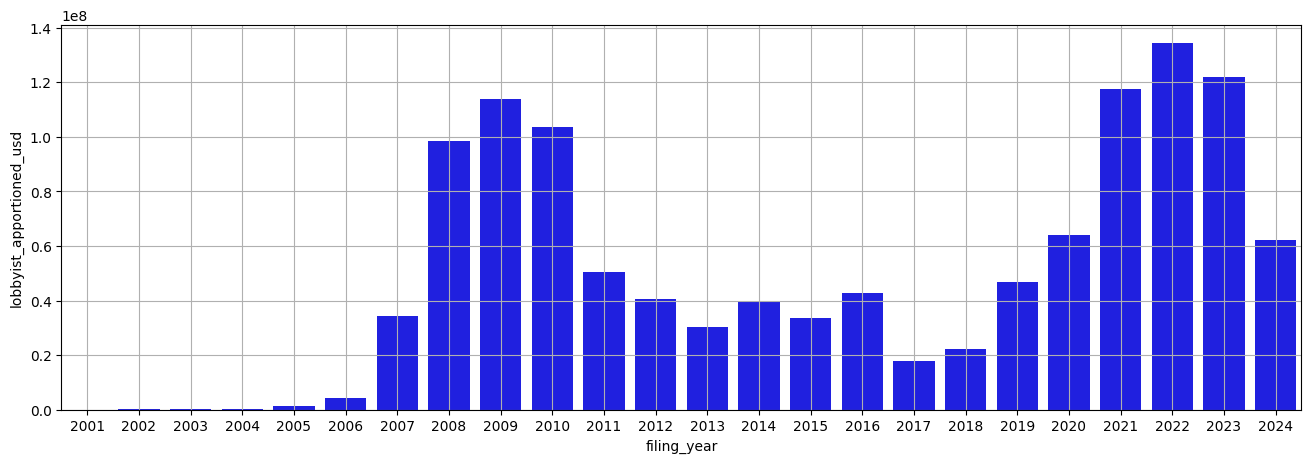

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
plot_df = (
    df[["filing_year", "lobbyist_apportioned_usd", "activity_apportioned_usd"]]
    .loc[df.likely_ccs == 1]
    .groupby(["filing_year"])
    .sum()
    .sort_values(by="lobbyist_apportioned_usd", ascending=False)
    .reset_index()
)
sns.barplot(
    data=plot_df, ax=ax, x="filing_year", y="lobbyist_apportioned_usd", color="blue"
)
ax.grid()

In [75]:
companies = list(
    df[["lobbyist_apportioned_usd", "client_rename"]]
    .loc[
        # (df.sector == "food and agriculture")
        (df["likely_ccs"] == 1)
        & (df.definitely_ccs == 0)
        # (df.sector == "renewable energy")
        # (df.sector == "other")
        # & (df.definitely_ccs == 1)
    ]
    .groupby("client_rename")
    .sum()
    .sort_values(by="lobbyist_apportioned_usd", ascending=False)
    .head(60)
    .index
)

In [76]:
for co in companies:
    print(f"************** {co} ************ ")
    for i, row in df.loc[
        (df.client_rename == co) & (df.likely_ccs == 1) & (df.definitely_ccs == 0)
    ].iterrows():
        if terms_present(row["clean_description"], maybe_ccs):
            print(f"maybe: {i}")
            print(row["description"])

            for i in maybe_ccs:
                if terms_present(row["clean_description"], [i]):
                    print(i)
        if terms_present(row["clean_description"], probably_ccs):
            print(f"probably: {i}")
            print(row["description"])

            for i in probably_ccs:
                if terms_present(row["clean_description"], [i]):
                    print(i)
        if terms_present(row["clean_description"], single_terms):
            print(f"single: {i}")
            print(row["description"])
            for i in single_terms:
                if terms_present(row["clean_description"], [i]):
                    print(i)
        if any(
            [
                terms_present(row["clean_description"], y, find_any=False)
                for y in multiple_terms
            ]
        ):
            print(f"multiple: {i}")
            print(row["clean_description"])
            for i in multiple_terms:
                if terms_present(row["clean_description"], i):
                    print(i)
        if row["ccs_bills"] == 1:
            print("---ccs bills!")
            print(row["clean_description"])
            for b in ccs_bills:
                if terms_present(row["clean_description"], [b]):
                    print(b)

************** CHEVRON ************ 
probably: 522
HR 741 Sustainable Aviation Fuel Act all provisions of the bill HR 1788 Clean Energy Hydrogen Innovation Act all provisions of the bill General Discussions Related to FUE no specific Bill Energy Prices Sustainable Aviation Fuels Hydrogen Fuels and Infrastructure Renewable Natural Gas Renewable DieselBiodiesel Environmental Protection Agency EPA Renewable Fuel Standard RFS Rulemakings Natural Gas Crude Oil and Petroleum Product Exports Pipeline and Hazardous Materials Safety Administration PHMSA Advanced Notice of Proposed Rule crude oil volatility Environmental Protection Agency EPAs Renewable Fuel Standard pathway technical discussion Environmental Protection Agency EPAs Fuel Pump Labelling Regulations Environmental Protection Agency EPAs Renewable Fuel Standard provisions related to renewable volume obligations Environmental Protection Agency EPAs Gasoline RVP standards

biodiesel
renewable natural gas
hydrogen
probably: 1446
HR 741 

In [74]:
terms_present("this is the phrase with terms", ["elephant", ["terms", "isle"]])

0

In [ ]:
sector_list = list(sector_mapping.keys())
for s1 in sector_list:
    for s2 in sector_list:
        if s1 != s2:
            if len(set(sector_mapping[s1]).intersection(set(sector_mapping[s2]))) > 0:
                print(f"Intersection of {s1} and {s2}:")
                print(
                    list(set(sector_mapping[s1]).intersection(set(sector_mapping[s2])))
                )

In [ ]:
for co in ["DARLING INGREDIENTS", "DARLING INTERNATIONAL"]:
    for i in list(
        ccs_df.loc[
            ccs_df.client_rename
            == co
            # ].clean_client_general_description.unique()
        ].client_name.unique()
    ):
        if "ELEPHANT" in i:
            print(f"'{i}':'DOW',")
        else:
            print(f"{i}: {substitute(i,use_basename=True)}")

In [ ]:
df.loc[
    (df.ccs_description == 1)
    | (df.ccs_company == 1)
    | (df.definitely_ccs == 1)
    | (df["probably ccs"] == 1)
    | ((df.oilandgas == 1) & (df["maybe ccs"] == 1))
    | ((df.utility == 1) & (df["maybe ccs"] == 1))
    | ((df.air_transport == 1) & (df["maybe ccs"] == 1))
    | ((df.land_transport == 1) & (df["maybe ccs"] == 1))
    | ((df.water_transport == 1) & (df["maybe ccs"] == 1))
    | ((df.biofuels == 1) & (df["maybe ccs"] == 1))
    | ((df.steel_company == 1) & (df["maybe ccs"] == 1))
][["lobbyist_apportioned_usd", "activity_apportioned_usd"]].sum()

In [ ]:
for i, row in df.loc[
    (df["maybe ccs"] == 1)
    & ((df.oilandgas == 1) | (df.utility == 1))
    & (df.ccs_description == 0)
].iterrows():
    print(f"{row['client_rename']}: {row['clean_description']}")

In [ ]:
for i, row in df.loc[
    (df["probably ccs"] == 1) & (df.oilandgas == 0) & (df.ccs_description == 0)
].iterrows():
    print(f"{row['client_rename']}: {row['clean_description']}")

In [ ]:
df.loc[df["potentially ccs"] == 1][
    ["lobbyist_apportioned_usd", "activity_apportioned_usd"]
].sum()

In [ ]:
sector_assignments = yaml_to_dict("sectors.yml")


all_companies = []
for _, value in sector_assignments.items():
    all_companies = all_companies + value
print(all_companies)

company_sector_dict = {}
for k, vv in sector_assignments.items():
    for v in vv:
        company_sector_dict = company_sector_dict | {v: k}

In [ ]:
company_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
lumped_sector_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/lumped_sectors.yml"
)["lumped_sector_assignments"]
df["sector"] = df["client_rename"].copy()
df["sector"] = [company_sector_dict[c] for c in df.sector]
df["lumped_sector"] = [lumped_sector_dict[c] for c in df.sector]

In [95]:
likely_ccs_by_year_sector_df = (
    df.loc[(df.lumped_sector != "REMOVE") & (df["likely_ccs"] == 1)][
        ["filing_year", "very_lumped_sector", "lobbyist_apportioned_usd"]
    ]
    .groupby(["filing_year", "very_lumped_sector"])
    .sum()
    .sort_values(by=["filing_year", "lobbyist_apportioned_usd"], ascending=False)
    .reset_index()
)
definitely_ccs_by_year_sector_df = (
    df.loc[(df.lumped_sector != "REMOVE") & (df["definitely_ccs"] == 1)][
        ["filing_year", "very_lumped_sector", "lobbyist_apportioned_usd"]
    ]
    .groupby(["filing_year", "very_lumped_sector"])
    .sum()
    .sort_values(by=["filing_year", "lobbyist_apportioned_usd"], ascending=False)
    .reset_index()
)

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns

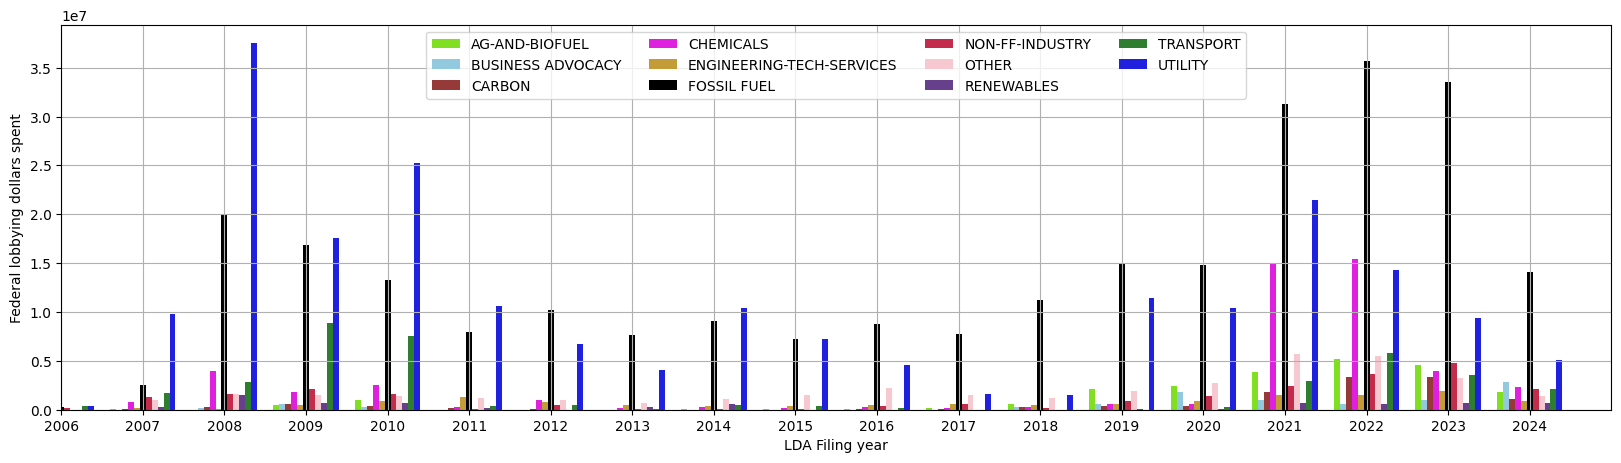

In [97]:
hue_order = [
    x
    for x in sorted(list(set(lumped_sector_dict["really_lumped"].values())))
    if x != "REMOVE"
]

colors = [
    "chartreuse",
    "skyblue",
    "brown",
    "magenta",
    "goldenrod",
    "black",
    "crimson",
    "pink",
    "rebeccapurple",
    "forestgreen",
    "blue",
    "grey",
    "tab:purple",
]
color_palette = sns.color_palette(colors)
palette = color_palette
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.barplot(
    ax=ax,
    data=definitely_ccs_by_year_sector_df,
    # data=likely_ccs_by_year_sector_df,
    x="filing_year",
    y="lobbyist_apportioned_usd",
    hue="very_lumped_sector",
    palette=color_palette,
    hue_order=hue_order,
)
ax.grid()
ax.legend(ncol=4, loc="upper center")
ax.set_xlim([5, 24])
ax.set_ylabel("Federal lobbying dollars spent")
ax.set_xlabel("LDA Filing year")
plt.show()

In [ ]:
for x in df.client_rename.loc[~df.client_rename.isin(all_companies)].unique():
    print(x.replace(",", ""))

In [ ]:
for i, row in df.clean_description.value_counts().items():
    print(i)

In [ ]:
df.client_general_description.fillna("", inplace=True)
df.loc[
    [
        ("ohio" in x.lower())  # | ("e&p" in x.lower())
        # for x in df.client_general_description
        for x in df.client_rename
    ]
].client_rename.unique()

In [ ]:
for i, row in df.client_rename.value_counts().items():
    print(f"{i}")

In [ ]:
df[["lobbyist_apportioned_usd", "client_rename"]].loc[df.ccs == 1].groupby(
    "client_rename"
).sum().sort_values(by="lobbyist_apportioned_usd", ascending=False).head(60)

In [ ]:
greenwashing_df.filing_id.nunique()

In [ ]:
greenwashing_df.loc[greenwashing_df.ccs == 1].groupby(
    "filing_id"
).first().reset_index().groupby("who_is_lobbying")["dollars_spent_lobbying"].sum()

In [ ]:
xom_entities = [x for x in df.columns if x in entities]
tmp = df[xom_entities].sum()
subset_entities = list(tmp[tmp > 0].index)
greenwashing_df = df.loc[df.ccs == 1].copy()
greenwashing_df[subset_entities].sum()

In [ ]:
search_string = '"carbon capture"OR"capture of carbon"OR"capture of co2"OR"CCUS"OR"CCS"OR"storage of carbon dioxide"OR"storage of co2"OR"capture and sequestration of carbon dioxide"OR"capture and sequestration of co2"OR"blue hydrogen"OR"hydrogen hub"OR"clean hydrogen"OR"45Q"OR"45V"OR"inflation reduction act"OR"117-169"OR"117-58"'

In [ ]:
query_filings = f"https://lda.senate.gov/api/v1/filings/?filing_specific_lobbying_issues={search_string}&filing_period=year_end"

f = requests.get(query_filings)

### Info about congress.gov search for bills with ccs relevance

In [ ]:
#query for congress.gov search
https://www.congress.gov/u/ISk7JcnkfFMeJIdw4sMwB

# "carbon capture" OR "capture of carbon" OR "CCUS" OR "CCS" OR "storage of carbon dioxide" OR "storage of co2" OR "sequestration of carbon dioxide" OR "sequestration of co2" OR "blue hydrogen" OR "clean hydrogen" OR "45Q" OR "45V"

In [ ]:
xom_word_cloud = [
    x.replace("Discussions related to", "")
    .replace("provisions", "")
    .replace("Provisions", "")
    for x in df.description.to_list()
]
xom_word_cloud = [
    x.replace("related", "")
    .replace("Related", "")
    .replace("issues", "")
    .replace("provisions related", "")
    for x in xom_word_cloud
]

In [ ]:
from wordcloud import WordCloud

word_cloud = WordCloud(background_color="white")
word_cloud.generate(" ".join(xom_word_cloud))
import os
from PIL import Image
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df[
    [
        "lobbyist_registrant_name",
        "client_name",
        "who_is_lobbying",
        "general_issue_code",
        "description",
    ]
]

In [ ]:
query_congress = f"https://api.congress.gov/v3/bill/118/hr/1262/summaries?format=json&api_key={data_gov_api_key}"
s = requests.get(query_congress)
s.json()["summaries"][-1]["text"]

In [ ]:
def parse_dollars_spent(income, expense):
    if (income is None) & (expense is None):
        return "income and expense are none", 0.0
    if income is None:
        return "corporation lobbying for itself", float(expense)
    if expense is None:
        return "hired lobbying firm", float(income)
    else:
        return "both income and expense > $0", float(income) + float(expense)


def initialize_row(entity_df, result, filing_id):
    # set up row dictionary using entity booleans
    initialize_row_dict = dict(
        zip(
            [x.lower() for x in list(entity_df["name"])],
            [0] * len(list(entity_df["name"])),
        )
    )
    (
        initialize_row_dict["who_is_lobbying"],
        initialize_row_dict["dollars_spent_lobbying"],
    ) = parse_dollars_spent(result["income"], result["expenses"])
    initialize_row_dict["filing_id"] = filing_id
    initialize_row_dict["url"] = result["url"]
    initialize_row_dict["filing_year"] = int(result["filing_year"])
    initialize_row_dict["filing_period"] = result["filing_period"]
    initialize_row_dict["lobbyist_posted_by_name"] = result["posted_by_name"]

    initialize_row_dict["lobbyist_registrant_id"] = result["registrant"]["id"]
    initialize_row_dict["lobbyist_registrant_name"] = result["registrant"]["name"]
    initialize_row_dict["lobbyist_registrant_contact"] = result["registrant"][
        "contact_name"
    ]
    initialize_row_dict["client_id"] = result["client"]["id"]
    initialize_row_dict["client_client_id"] = result["client"]["client_id"]
    initialize_row_dict["client_name"] = result["client"]["name"]
    initialize_row_dict["affiliated_organizations_present"] = False
    if len(result["affiliated_organizations"]) > 0:
        initialize_row_dict["affiliated_organizations_present"] = True
    initialize_row_dict["convictions_present"] = False
    if len(result["conviction_disclosures"]) > 0:
        initialize_row_dict["convictions_present"] = True
    return initialize_row_dict

In [ ]:
def parse_lobbyists(df, lobbyists, details):
    lobby_dict = {}
    lobby_dict["firm_name"] = details["lobbyist_registrant_name"]
    lobby_dict["client_name"] = details["client_name"]
    lobby_dict["general_issue_code"] = details["general_issue_code"]
    lobby_dict["description"] = details["description"]
    lobby_dict["filing_period"] = details["filing_period"]
    lobby_dict["filing_year"] = details["filing_year"]
    lobby_dict["url"] = details["url"]
    lobby_dict["filing_id"] = details["filing_id"]

    lobby_list = []
    # unpack lobbyists list
    for lobbyist in lobbyists:
        lobby_dict["name"] = (
            lobbyist["lobbyist"]["last_name"]
            + ", "
            + lobbyist["lobbyist"]["first_name"]
        )
        lobby_dict["covered_position"] = "None"
        if "covered_position" in lobbyist:
            lobby_dict["covered_position"] = lobbyist["covered_position"]
        lobby_dict["id"] = lobbyist["lobbyist"]["id"]
        lobby_list.append(lobby_dict.copy())

    if df is None:
        df = pd.DataFrame(
            columns=[
                "name",
                "firm_name",
                "client_name",
                "general_issue_code",
                "description",
                "covered_position",
                "filing_year",
                "filing_period",
                "url",
            ]
        )

    df = pd.concat([df, pd.DataFrame(lobby_list)])
    return df

In [ ]:
# get govt entity names
entity_df = pd.DataFrame(government_entities)

corporations = [
    "Exxon",
    "ExxonMobil",
]  # 'exxon' alone includes ExxonMobil Exxon Mobil Corp, Exxon Mobil Corporation, etc. ['Exxon Mobil'.upper(),'ExxonMobil'.upper(),'Exxon'

row_list = (
    []
)  # initialize holder for each row (which corresponds to a single lobbying activity)
max_page = 20

filing_id = 0
lobbyists_df = None
for corporation in corporations:
    for year in list(range(1999, 2025)):
        page = 1
        while page < max_page:
            # print(f"Querying page {page} for year {year}")
            query_filings = f'https://lda.senate.gov/api/v1/filings/?client_name="{corporation}"&filing_period=year_end&filing_year={year}&page={page}'

            f = requests.get(query_filings)

            if "detail" in f.json():
                break

            results = f.json()["results"]
            page += 1  # increase the page for the next query
            # print(f"{len(results)} filings found")
            if len(results) < 25:
                page = max_page

            for result in results:
                row_dict_base = initialize_row(entity_df, result, filing_id)
                activities = result["lobbying_activities"]

                for activity_count, activity in enumerate(activities):
                    row_dict = row_dict_base.copy()
                    # set up row dictionary using entity booleans
                    row_dict["activity_count"] = activity_count
                    row_dict["general_issue_code"] = activity["general_issue_code"]
                    row_dict["description"] = activity["description"]
                    lobbyists_df = parse_lobbyists(
                        lobbyists_df, activity["lobbyists"], row_dict
                    )

                    lobbyist_id_list = []
                    for lobbyist in activity["lobbyists"]:
                        lobbyist_id_list.append(lobbyist["lobbyist"]["id"])

                    row_dict["lobbyist_ids"] = "; ".join(
                        ["None" if x is None else str(x) for x in lobbyist_id_list]
                    )
                    for entity in activity["government_entities"]:
                        row_dict[entity["name"].lower()] = 1

                    row_list.append(row_dict.copy())

                    row_dict.clear()
                filing_id += 1

tmp = pd.DataFrame(row_list)
entities_influenced = tmp[[x.lower() for x in list(entity_df["name"])]].sum()
zeroed = list(entities_influenced[entities_influenced == 0].index)
xom_df = tmp[[x for x in tmp.columns.values if x not in zeroed]]
xom_df = xom_df.drop_duplicates(subset=xom_df.columns.difference(["filing_id"]))
xom_unique_filing_ids = list(
    xom_df.filing_id.unique()
)  # keep a list of the non-duplicate filing ids

# keep only right company aliases
company_aliases = [
    "EXXON MOBIL CORP",
    "EXXONMOBIL CHEMICAL CO",
    "EXXON USA",
    "EXXON CO USA",
    "EXXON MOBIL CORPORATION",
    "EXXON MOBIL PRODUCTION CO",
    "EXXON MOBIL",
    "EXXONMOBIL CORPORATION",
    "EXXONMOBIL CORP",
    "EXXON MOBILE",
    "EXXONMOBIL GLOBAL SERVICES COMPANY",
    "DCI GROUP, LLC, ON BEHALF OF EXXONMOBIL",
    "EXXONMOBIL",
    "HUNTON ANDREWS KURTH LLP (FORMERLY HUNTON & WILLIAMS LLP BEHALF OF EXXON MOBIL)",
    "EXXON MOBIL COPORATION",
    "EXXON MOBIL CORP.",
]
xom_df = xom_df.loc[xom_df.client_name.isin(company_aliases)]


lobbyists_df = lobbyists_df.loc[
    (lobbyists_df.client_name.isin(company_aliases))
    & (lobbyists_df.filing_id.isin(xom_unique_filing_ids))
]

xom_df["which_congress"] = [which_congress(y) for y in xom_df["filing_year"]]

In [ ]:
test_df[["which_congress", "description"]].loc[
    [x != "" for x in test_df.description]
].to_clipboard()

In [ ]:
# how much money has exxonmobil spent lobbying congress in 25 years?
xom_df[["dollars_spent_lobbying", "filing_id"]].groupby("filing_id").first()[
    "dollars_spent_lobbying"
].sum()

In [ ]:
xom_df.to_csv("xom_lda_filings.csv")
lobbyists_df.to_csv("xom_lobbyists.csv")

In [ ]:
tmp = (
    xom_df[
        [
            "dollars_spent_lobbying",
            "lobbyist_registrant_name",
            "filing_id",
            "filing_year",
        ]
    ]
    .groupby(["lobbyist_registrant_name", "filing_id"])
    .first()
    .reset_index()
)

In [ ]:
tmp.info()

In [ ]:
total_dollars_spent_df = (
    tmp.groupby("lobbyist_registrant_name")
    .agg(
        {
            "dollars_spent_lobbying": "sum",
            "filing_id": "count",
            "filing_year": "min",
            "filing_year": "min",
        }
    )
    .sort_values(by="dollars_spent_lobbying", ascending=False)
)
total_dollars_spent_df.columns = [
    "dollars_spent_lobbying",
    "total_lda_filings",
    "earliest_filing_year",
]
max_year_df = (
    tmp[["lobbyist_registrant_name", "filing_year"]]
    .groupby("lobbyist_registrant_name")
    .agg({"filing_year": "max"})
)
max_year_df.columns = ["latest_filing_year"]
total_dollars_spent_df = total_dollars_spent_df.merge(
    max_year_df, right_index=True, left_index=True
)
total_dollars_spent_df

In [ ]:
xom_dci_lobbyists = list(
    lobbyists_df.loc[lobbyists_df.firm_name == "DCI GROUP, L.L.C."].name.unique()
)

In [ ]:
counts_df = (
    lobbyists_df[["name", "firm_name"]]
    .groupby("firm_name")
    .count()
    .sort_values(by="name")
)
counts_df.columns = ["firm_total_filings"]
df = lobbyists_df.merge(counts_df, left_on="firm_name", right_index=True)
counts_df = (
    lobbyists_df[["name", "firm_name"]]
    .groupby("name")
    .count()
    .sort_values(by="firm_name")
)
counts_df.columns = ["total_number_of_filings"]
df = df.merge(counts_df, left_on="name", right_index=True)

In [ ]:
lobbyists_df[["name", "firm_name", "client_name", "total_number_of_filings"]].groupby(
    "name"
).first().sort_values(by="total_number_of_filings", ascending=False).head(50)

In [ ]:
lob1 = requests.get(
    'https://lda.senate.gov/api/v1/lobbyists/?registrant_name="DCI GROUP, L.L.C."&page=1'
)
lob2 = requests.get(
    'https://lda.senate.gov/api/v1/lobbyists/?registrant_name="DCI GROUP, L.L.C."&page=2'
)
dci_lobbyists = lob1.json()["results"] + lob2.json()["results"]

In [ ]:
all_dci_lobbyists = []
for dci in dci_lobbyists:
    all_dci_lobbyists.append(dci["last_name"] + ", " + dci["first_name"])

sorted(all_dci_lobbyists)

In [ ]:
xom_df.loc[xom_df.f]

In [ ]:
xom_dci_lobbyists

In [ ]:
xom_dict={}
for x in xom:
    xom_dict['year']=int(x['filing_year'])
    xom_dict['rest']=

In [ ]:
lob = requests.get("https://lda.senate.gov/api/v1/lobbyists/")
filing_types = requests.get(
    "https://lda.senate.gov/api/v1/constants/filing/filingtypes/"
)
general_issues = requests.get(
    "https://lda.senate.gov/api/v1/constants/filing/lobbyingactivityissues/"
)
govt_entities = requests.get(
    "https://lda.senate.gov/api/v1/constants/filing/governmententities/"
)
countries = requests.get("https://lda.senate.gov/api/v1/constants/general/countries/")
states = requests.get("https://lda.senate.gov/api/v1/constants/general/states/")
prefixes = requests.get("https://lda.senate.gov/api/v1/constants/lobbyist/prefixes/")
suffixes = requests.get("https://lda.senate.gov/api/v1/constants/lobbyist/suffixes/")
contribution_items = requests.get(
    "https://lda.senate.gov/api/v1/constants/contribution/itemtypes/"
)

In [ ]:
lob = requests.get(
    'https://lda.senate.gov/api/v1/lobbyists/?registrant_name="DCI GROUP, L.L.C."&page=2'
)
lob.json()["results"]

In [ ]:
contributions = []
for page in range(1, 4):
    c = requests.get(
        f'https://lda.senate.gov/api/v1/contributions/?registrant_name="DCI GROUP, L.L.C."&filing_type=YY&page={page}'
    )
    contributions = contributions + c.json()["results"]

In [ ]:
row_list = []

for dci in contributions:
    row_dict = {}
    for i in dci["contribution_items"]:
        row_dict["contribution_type"] = i["contribution_type"]
        row_dict["contributor_name"] = i["contributor_name"]
        row_dict["payee_name"] = i["payee_name"]
        row_dict["honoree_name"] = i["honoree_name"]
        row_dict["usd"] = float(i["amount"])
        row_dict["date"] = i["date"]
        row_dict["filing_year"] = dci["filing_year"]
        row_dict["registrant_name"] = dci["registrant"]["name"]
        row_list.append(row_dict.copy())
dci_contributions_df = pd.DataFrame(row_list)

In [ ]:
def strip_terms(x, terms):
    for term in terms:
        x = x.replace(term, "")

    return x.split(" (")[0].title()

In [ ]:
terms = [
    "Senator ",
    "US ",
    "Rep. ",
    "U.S. ",
    "Representative ",
    "Sen. ",
    "Congressional ",
    "Candidate ",
    "Congressman ",
    "for ",
    "Friends of ",
]

print(dci_contributions_df.honoree_name.nunique())
print(dci_contributions_df.stripped_honoree_name.nunique())

In [ ]:
dci_contributions_df.honoree_name.unique()
terms = [
    "Senator ",
    "US ",
    "Rep. ",
    "Congresswoman ",
    "U.S. ",
    " 08",
    " Jr.",
    "Jr",
    "Resident Commissioner of Puerto Rico ",
    "Senate ",
    "Campaign",
    "Presidential ",
    "candidate ",
    "Candidate ",
    "Representative ",
    "Sen. ",
    "House ",
    "Congressional ",
    "Candidate ",
    "Representative-Elect ",
    "Campaign Committee",
    "Committee",
    "Congressman ",
    "for ",
    "Friends of ",
    " Senate",
    " Congress",
    "Friend of ",
    "- In-Kind Donation",
]
dci_contributions_df["stripped_honoree_name"] = [
    strip_terms(x, terms) for x in dci_contributions_df.honoree_name
]
dci_contributions_df.stripped_honoree_name.unique()

In [ ]:
yy = list(dci_contributions_df.stripped_honoree_name.unique())
dci_contributions_df["stripped_honoree_name"] = [
    x.strip() for x in dci_contributions_df["stripped_honoree_name"]
]
dci_contributions_df["stripped_honoree_name_sim"] = dci_contributions_df[
    "stripped_honoree_name"
]
for y in yy:
    dci_contributions_df["stripped_honoree_name_sim"] = [
        y if x in y else x for x in dci_contributions_df.stripped_honoree_name_sim
    ]
yy = list(dci_contributions_df.stripped_honoree_name_sim.unique())
for y in yy:
    dci_contributions_df["stripped_honoree_name_sim"] = [
        y if x in y else x for x in dci_contributions_df.stripped_honoree_name_sim
    ]

In [ ]:
yy = list(dci_contributions_df.stripped_honoree_name_sim.unique())
for term, replacement in {
    "Allan": "Alan",
    "Jim": "James",
    "Gordan": "Gordon",
    "&": "And",
    "Georgians": "Johnny",
    "M.": "Mary",
    "Pete": "Peter",
}.items():
    dci_contributions_df["stripped_honoree_name_sim"] = [
        x.replace(term, replacement)
        for x in dci_contributions_df.stripped_honoree_name_sim
    ]

In [ ]:
dci_contributions_df[["stripped_honoree_name_sim", "usd"]].groupby(
    "stripped_honoree_name_sim"
).sum().sort_values(by="usd", ascending=False).sum()

In [ ]:
import pandas as pd
from name_matching.name_matcher import NameMatcher

# define a dataset with bank names
df_a = pd.DataFrame({"recipient1": y})

# alter each of the bank names a bit to test the matching
df_b = pd.DataFrame({"recipient2": sorted(y)})

# initialise the name matcher
matcher = NameMatcher(
    number_of_matches=5, legal_suffixes=True, common_words=False, top_n=50, verbose=True
)

# adjust the distance metrics to use
matcher.set_distance_metrics(["bag", "typo", "refined_soundex"])

# load the data to which the names should be matched
matcher.load_and_process_master_data(
    column="recipient1", df_matching_data=df_a, transform=True
)

# perform the name matching on the data you want matched
matches = matcher.match_names(to_be_matched=df_b, column_matching="recipient2")

# combine the datasets based on the matches
# combined = pd.merge(df_a, matches, how='left', left_index=True, right_on='match_index')
# combined#combined = pd.merge(combined, df_b, how='left', left_index=True, right_index=True)

In [ ]:
# matches.drop(['match_name_0','score_0'],axis=1,inplace=True)
matches

In [ ]:
dci_contributions_df[["filing_year", "usd"]].groupby("filing_year").sum()

In [ ]:
firms = []
# lobbyists=lobbyists.json()['results']
for lobby in lobbyists:
    print(lobby)
    firms.append(lobby["registrant"]["name"])

In [ ]:
firms

In [ ]:
payee = "Friends of Max Baucus".replace(" ", "%20")
year = "2008"
contributor = "Crossroads Strategies, LLC".replace(" ", "%20")
year = "2023"
query_all_contributions = f"https://lda.senate.gov/api/v1/contributions/?contribution_payee={payee}&filing_year={year}"
c = requests.get(query_all_contributions)
baucus = c.json()["results"]

In [ ]:
contributor = "Crossroads Strategies".replace(" ", "%20")
year = "2023"
query_all_contributions = f"https://lda.senate.gov/api/v1/contributions/?contribution_contributor={contributor}&filing_year={year}"
c = requests.get(query_all_contributions)
crossroads = c.json()["results"]

In [ ]:
crossroads

In [ ]:
total = 0

for cc in baucus:
    contributions = cc["contribution_items"]
    for i in contributions:
        if i["payee_name"].lower() == "friends of max baucus":
            print(f'{i["contributor_name"]}, amount: ${i["amount"]}')
            total = total + float(i["amount"])

In [ ]:
total

In [ ]:
govt_entities_df = pd.DataFrame(govt_entities.json())
contribution_items_df = pd.DataFrame(contribution_items.json())
general_issues_df = pd.DataFrame(general_issues.json())
filing_types_df = pd.DataFrame(filing_types.json())

In [ ]:
constants = requests.get("https://lda.senate.gov/api/v1/constants/")
constants.json()

In [ ]:
r.json()

In [ ]:
rr = requests.get(r.json()["filings"] + "?client_name=exxon%20mobil&filing_year=2023")

In [ ]:
rr.json()

In [ ]:
rr.json()["results"][0].keys()

dictionary = rr.json()["results"][0]
dictionary = flatten(dictionary)

for key, value in dictionary.items():
    print(f"{key}: {value}")

In [ ]:
flatten(dictionary)

In [ ]:
query = f"https://developer.nrel.gov/api/pvwatts/v8.json?api_key={config['apikey']}&lat={lat}&lon={lon}&system_capacity={config['kw']}&azimuth={azimuth}&tilt={tilt}&array_type=1&module_type=1&losses=10"
                response = requests.get(query, timeout=20)
                info_dict["ac_annual"] = response.json()["outputs"]["ac_annual"]